In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns
from tqdm.notebook import tqdm
import pickle

from sklearn.linear_model import LinearRegression
from statsmodels.regression.rolling import RollingOLS
import arch

from src.backtesting import *
from src.trading import *
from src.laplacian_estimators import *
from src.preprocessing import *

In [2]:
def sharpe_ratio(x):
    return x.mean() / x.std() * np.sqrt(12)

def sortino_ratio(x):
    mean = x.mean()
    std_neg = x[x<0].std()
    return mean / std_neg * np.sqrt(12)

# Load Data

## Load Stocks Data

In [3]:
# SP500 Data
prices = pd.read_csv("./data/sp500_prices_long.csv", parse_dates=['Date'])
prices['month'] = prices['Date'].dt.month
prices['year'] = prices['Date'].dt.year
raw_monthly_prices = prices.groupby(['year', 'month']).last().reset_index()
raw_monthly_prices['year_month'] = raw_monthly_prices['year'].astype(str) + ('00' + raw_monthly_prices['month'].astype(str)).str[-2:]
raw_monthly_prices = raw_monthly_prices.set_index('year_month').drop(columns=['year', 'month', 'Date'])
monthly_prices = raw_monthly_prices.loc[:, raw_monthly_prices.isna().mean(axis=0) < .5]
monthly_log_returns = np.log(monthly_prices).diff().iloc[1:]
monthly_log_returns = np.exp(monthly_log_returns) - 1
monthly_log_returns.head()

,A,AAL,AAP,AAPL,ABC,ABMD,ABT,ACN,ADBE,ADI,...,WST,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH,ZBRA,ZION
year_month,,,,,,,,,,,,,,,,,,,,,
199502,NaN,NaN,NaN,-0.018981,NaN,0.555556,0.003533,NaN,0.235421,0.168606,...,-0.037036,0.075907,NaN,-0.021621,0.034362,-0.049999,NaN,NaN,-0.090625,0.059603
199503,NaN,NaN,NaN,-0.107596,NaN,-0.171429,0.007043,NaN,0.385995,0.014925,...,-0.019232,-0.046012,NaN,-0.027624,0.043053,0.047373,NaN,NaN,0.127148,-0.048934
199504,NaN,NaN,NaN,0.085107,NaN,0.206897,0.107499,NaN,0.176768,0.053921,...,0.102896,0.080386,NaN,0.020997,0.043151,0.014389,NaN,NaN,0.118902,0.129139
199505,NaN,NaN,NaN,0.089615,0.028249,-0.028571,0.015873,NaN,-0.107296,0.158139,...,0.004465,0.054687,NaN,0.070621,0.037924,0.021277,NaN,NaN,-0.019073,0.061584
199506,NaN,NaN,NaN,0.117294,0.002747,0.014706,0.012500,NaN,0.115385,0.092370,...,-0.004445,0.074074,NaN,-0.026385,-0.010507,0.002102,NaN,NaN,0.183333,0.112762


## Load Factors Data

In [4]:
factors = pd.read_csv("./data/F-F_Research_Data_5_Factors_2x3.csv", skiprows=2)
factors = factors[factors['Date'].astype(str).str.strip().str.len() == 6]
factors = factors.set_index('Date')
factors = factors.astype(np.float64)
factors

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
196307,-0.39,-0.41,-0.97,0.68,-1.18,0.27
196308,5.07,-0.80,1.80,0.36,-0.35,0.25
196309,-1.57,-0.52,0.13,-0.71,0.29,0.27
196310,2.53,-1.39,-0.10,2.80,-2.01,0.29
196311,-0.85,-0.88,1.75,-0.51,2.24,0.27
...,...,...,...,...,...,...
202205,-0.34,-0.06,8.41,1.44,3.98,0.03
202206,-8.43,1.30,-5.97,1.85,-4.70,0.06
202207,9.57,1.88,-4.10,0.68,-6.94,0.08


## Marge Indexes

In [5]:
idx = monthly_log_returns.merge(factors, right_index=True, left_index=True).index
monthly_log_returns = monthly_log_returns.loc[idx]
factors = factors.loc[idx]

## Remove Risk-free Returns

In [6]:
monthly_log_returns_rf = monthly_log_returns - factors[['RF']].values / 100
factors_rf = factors.drop(columns='RF')

# Backtest Strategies

In [7]:
split_window_size = 12
config_backtesters = dict()

In [11]:
trading_rules_dict = ({f'decile-{d}': BuyDecileTradingRule(d) for d in range(1, 11)} |
                      {'q=0.2': QuantilesTradingRule(q=0.2)}
)

# Identity
config_backtesters['NoPreprocessing Identity'] = ConfigBacktester(
    preprocessor=NoPreprocessing(),
    trader=SpreadsTrader(
        laplacian_estimator=LaplacianIdentityLaplacianEstimator(),
        trading_rule=trading_rules_dict
    ),
    split_window_size=split_window_size
)

config_backtesters['Residuals Identity'] = ConfigBacktester(
    preprocessor=ResidualsPreprocessing(factors_rf),
    trader=SpreadsTrader(
        laplacian_estimator=LaplacianIdentityLaplacianEstimator(),
        trading_rule=trading_rules_dict
    ),
    split_window_size=split_window_size
)

# Corr-50
config_backtesters['NoPreprocessing Corr-50'] = ConfigBacktester(
    preprocessor=NoPreprocessing(),
    trader=SpreadsTrader(
        laplacian_estimator=LaplacianCorrKLaplacianEstimator(k=50),
        trading_rule=trading_rules_dict
    ),
    split_window_size=split_window_size
)

config_backtesters['Residuals Corr-50'] = ConfigBacktester(
    preprocessor=ResidualsPreprocessing(factors_rf),
    trader=SpreadsTrader(
        laplacian_estimator=LaplacianCorrKLaplacianEstimator(k=50),
        trading_rule=trading_rules_dict
    ),
    split_window_size=split_window_size
)

In [14]:
# Pairs-5
config_backtesters['NoPreprocessing Pairs-5'] = ConfigBacktester(
    preprocessor=NoPreprocessing(),
    trader=PairsDistanceTrader(5),
    split_window_size=split_window_size
)

config_backtesters['Residuals Pairs-5'] = ConfigBacktester(
    preprocessor=ResidualsPreprocessing(factors_rf),
    trader=PairsDistanceTrader(5),
    split_window_size=split_window_size
)

# Pairs-20

config_backtesters['NoPreprocessing Pairs-20'] = ConfigBacktester(
    preprocessor=NoPreprocessing(),
    trader=PairsDistanceTrader(20),
    split_window_size=split_window_size
)

config_backtesters['Residuals Pairs-20'] = ConfigBacktester(
    preprocessor=ResidualsPreprocessing(factors_rf),
    trader=PairsDistanceTrader(20),
    split_window_size=split_window_size
)


In [12]:
backtester = GridBacktester(config_backtesters, verbose=True)

In [13]:
config_returns = backtester.fit_backtest(monthly_log_returns)
config_returns

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.67it/s]


Strategy    NoPreprocessing Identity                                          \
TradingRule                 decile-1  decile-2  decile-3  decile-4  decile-5   
200002                      0.135034  0.131390  0.154990  0.091904  0.147744   
200003                     -0.028588  0.041802 -0.026969  0.049482  0.036466   
200004                      0.037814  0.038920 -0.043700  0.009353  0.014866   
200005                      0.047567 -0.011865 -0.008008  0.009434  0.030769   
200006                      0.044216  0.064178  0.036168  0.056404  0.003652   
...                              ...       ...       ...       ...       ...   
202109                      0.071524  0.053179  0.037374  0.059270  0.066754   
202110                     -0.052992 -0.033909 -0.045252  0.004581 -0.022021   
202111                      0.092279  0.075183  0.050994  0.050623  0.069477   
202112                     -0.048858 -0.003517 -0.023103 -0.055227 -0.052287   
202201                     -0.036062 -0.027268 -0.027528 -0.031949 -0.014747   

Strategy                                                       ...  \
TradingRule  decile-6  decile-7  decile-8  decile-9 decile-10  ...   
200002       0.104761  0.145046  0.104694  0.098369 -0.083457  ...   
200003       0.023741  0.026190  0.001183  0.040857 -0.000495  ...   
200004       0.037765  0.062658 -0.004038  0.005043  0.025043  ...   
200005      -0.027682 -0.051023 -0.017754 -0.025633 -0.049759  ...   
200006       0.012035  0.029667  0.024846  0.008790 -0.030318  ...   
...               ...       ...       ...       ...       ...  ...   
202109       0.061993  0.043719  0.045245  0.027934  0.070246  ...   
202110      -0.021224 -0.022781 -0.022696 -0.010840 -0.008155  ...   
202111       0.083278  0.080044  0.074059  0.054419  0.062897  ...   
202112      -0.058721 -0.056640 -0.026738 -0.029136 -0.040161  ...   
202201      -0.007454  0.006671  0.011464  0.011082  0.013003  ...   

Strategy    Residuals Corr-50                                          \
TradingRule          decile-2  decile-3  decile-4  decile-5  decile-6   
200002               0.073360  0.069276  0.097823  0.071020  0.151011   
200003              -0.005184 -0.001322  0.028168  0.038532  0.048078   
200004               0.027212  0.080265  0.024431  0.026271  0.017683   
200005              -0.001153 -0.023050 -0.010020 -0.022566  0.037287   
200006              -0.015597  0.020634  0.059244  0.011725  0.022811   
...                       ...       ...       ...       ...       ...   
202109               0.037981  0.047106  0.036576  0.032510  0.043007   
202110              -0.060542 -0.033987 -0.031293 -0.021426 -0.009098   
202111               0.082130  0.080754  0.065423  0.066762  0.075960   
202112              -0.034624 -0.022931 -0.038433 -0.066234 -0.063553   
202201               0.000746 -0.031105  0.011062 -0.008948 -0.009256   

Strategy                                                       
TradingRule  decile-7  decile-8  decile-9 decile-10     q=0.2  
200002       0.138541  0.165493  0.138128  0.125554 -0.120662  
200003       0.013252 -0.005541  0.056689  0.007234 -0.014085  
200004       0.017968  0.010039 -0.048282 -0.059483  0.165718  
200005       0.002776  0.003275 -0.000713 -0.005634 -0.068352  
200006       0.022907  0.017590  0.059570  0.028888 -0.000438  
...               ...       ...       ...       ...       ...  
202109       0.065233  0.088250  0.079437  0.087534 -0.071931  
202110      -0.006827 -0.010661 -0.002079  0.011781 -0.087701  
202111       0.068003  0.070465  0.048079  0.047450  0.036105  
202112      -0.020036 -0.053758 -0.042790 -0.014014 -0.022897  
202201      -0.017430 -0.019316 -0.001765 -0.004370 -0.013146  

[264 rows x 44 columns]

In [58]:
file_name = 'grid_backtester.pkl'
# with open(file_name, 'wb') as file:
#     pickle.dump(backtester, file)
# config_returns.to_csv('results/config_returns.csv')

In [12]:
config_returns += factors.loc[config_returns.index,['RF']].values / 100

In [13]:
# config_returns = pd.read_csv('results/config_returns.csv', index_col='Date')
# config_returns.index = pd.to_datetime(config_returns.index.astype('str') + '01')
config_returns.index = config_returns.index.astype('str')
config_returns

NoPreprocessing Identity                                          \
                       decile-1  decile-2  decile-3  decile-4  decile-5   
200002                 0.139334  0.135690  0.159290  0.096204  0.152044   
200003                -0.023888  0.046502 -0.022269  0.054182  0.041166   
200004                 0.042414  0.043520 -0.039100  0.013953  0.019466   
200005                 0.052567 -0.006865 -0.003008  0.014434  0.035769   
200006                 0.048216  0.068178  0.040168  0.060404  0.007652   
...                         ...       ...       ...       ...       ...   
202109                 0.071524  0.053179  0.037374  0.059270  0.066754   
202110                -0.052992 -0.033909 -0.045252  0.004581 -0.022021   
202111                 0.092279  0.075183  0.050994  0.050623  0.069477   
202112                -0.048758 -0.003417 -0.023003 -0.055127 -0.052187   
202201                -0.036062 -0.027268 -0.027528 -0.031949 -0.014747   

                                                          ...  \
        decile-6  decile-7  decile-8  decile-9 decile-10  ...   
200002  0.109061  0.149346  0.108994  0.102669 -0.079157  ...   
200003  0.028441  0.030890  0.005883  0.045557  0.004205  ...   
200004  0.042365  0.067258  0.000562  0.009643  0.029643  ...   
200005 -0.022682 -0.046023 -0.012754 -0.020633 -0.044759  ...   
200006  0.016035  0.033667  0.028846  0.012790 -0.026318  ...   
...          ...       ...       ...       ...       ...  ...   
202109  0.061993  0.043719  0.045245  0.027934  0.070246  ...   
202110 -0.021224 -0.022781 -0.022696 -0.010840 -0.008155  ...   
202111  0.083278  0.080044  0.074059  0.054419  0.062897  ...   
202112 -0.058621 -0.056540 -0.026638 -0.029036 -0.040061  ...   
202201 -0.007454  0.006671  0.011464  0.011082  0.013003  ...   

       Residuals Corr-50                                                    \
                decile-2  decile-3  decile-4  decile-5  decile-6  decile-7   
200002          0.077660  0.073576  0.102123  0.075320  0.155311  0.142841   
200003         -0.000484  0.003378  0.032868  0.043232  0.052778  0.017952   
200004          0.031812  0.084865  0.029031  0.030871  0.022283  0.022568   
200005          0.003847 -0.018050 -0.005020 -0.017566  0.042287  0.007776   
200006         -0.011597  0.024634  0.063244  0.015725  0.026811  0.026907   
...                  ...       ...       ...       ...       ...       ...   
202109          0.037981  0.047106  0.036576  0.032510  0.043007  0.065233   
202110         -0.060542 -0.033987 -0.031293 -0.021426 -0.009098 -0.006827   
202111          0.082130  0.080754  0.065423  0.066762  0.075960  0.068003   
202112         -0.034524 -0.022831 -0.038333 -0.066134 -0.063453 -0.019936   
202201          0.000746 -0.031105  0.011062 -0.008948 -0.009256 -0.017430   

                                                
        decile-8  decile-9 decile-10     q=0.2  
200002  0.169793  0.142428  0.129854 -0.116362  
200003 -0.000841  0.061389  0.011934 -0.009385  
200004  0.014639 -0.043682 -0.054883  0.170318  
200005  0.008275  0.004287 -0.000634 -0.063352  
200006  0.021590  0.063570  0.032888  0.003562  
...          ...       ...       ...       ...  
202109  0.088250  0.079437  0.087534 -0.071931  
202110 -0.010661 -0.002079  0.011781 -0.087701  
202111  0.070465  0.048079  0.047450  0.036105  
202112 -0.053658 -0.042690 -0.013914 -0.022797  
202201 -0.019316 -0.001765 -0.004370 -0.013146  

[264 rows x 44 columns]

In [18]:
config_returns.index.name = 'Date'
config_returns

NoPreprocessing Identity                                          \
                       decile-1  decile-2  decile-3  decile-4  decile-5   
Date                                                                      
200002                 0.139334  0.135690  0.159290  0.096204  0.152044   
200003                -0.023888  0.046502 -0.022269  0.054182  0.041166   
200004                 0.042414  0.043520 -0.039100  0.013953  0.019466   
200005                 0.052567 -0.006865 -0.003008  0.014434  0.035769   
200006                 0.048216  0.068178  0.040168  0.060404  0.007652   
...                         ...       ...       ...       ...       ...   
202109                 0.071524  0.053179  0.037374  0.059270  0.066754   
202110                -0.052992 -0.033909 -0.045252  0.004581 -0.022021   
202111                 0.092279  0.075183  0.050994  0.050623  0.069477   
202112                -0.048758 -0.003417 -0.023003 -0.055127 -0.052187   
202201                -0.036062 -0.027268 -0.027528 -0.031949 -0.014747   

                                                          ...  \
        decile-6  decile-7  decile-8  decile-9 decile-10  ...   
Date                                                      ...   
200002  0.109061  0.149346  0.108994  0.102669 -0.079157  ...   
200003  0.028441  0.030890  0.005883  0.045557  0.004205  ...   
200004  0.042365  0.067258  0.000562  0.009643  0.029643  ...   
200005 -0.022682 -0.046023 -0.012754 -0.020633 -0.044759  ...   
200006  0.016035  0.033667  0.028846  0.012790 -0.026318  ...   
...          ...       ...       ...       ...       ...  ...   
202109  0.061993  0.043719  0.045245  0.027934  0.070246  ...   
202110 -0.021224 -0.022781 -0.022696 -0.010840 -0.008155  ...   
202111  0.083278  0.080044  0.074059  0.054419  0.062897  ...   
202112 -0.058621 -0.056540 -0.026638 -0.029036 -0.040061  ...   
202201 -0.007454  0.006671  0.011464  0.011082  0.013003  ...   

       Residuals Corr-50                                                    \
                decile-2  decile-3  decile-4  decile-5  decile-6  decile-7   
Date                                                                         
200002          0.077660  0.073576  0.102123  0.075320  0.155311  0.142841   
200003         -0.000484  0.003378  0.032868  0.043232  0.052778  0.017952   
200004          0.031812  0.084865  0.029031  0.030871  0.022283  0.022568   
200005          0.003847 -0.018050 -0.005020 -0.017566  0.042287  0.007776   
200006         -0.011597  0.024634  0.063244  0.015725  0.026811  0.026907   
...                  ...       ...       ...       ...       ...       ...   
202109          0.037981  0.047106  0.036576  0.032510  0.043007  0.065233   
202110         -0.060542 -0.033987 -0.031293 -0.021426 -0.009098 -0.006827   
202111          0.082130  0.080754  0.065423  0.066762  0.075960  0.068003   
202112         -0.034524 -0.022831 -0.038333 -0.066134 -0.063453 -0.019936   
202201          0.000746 -0.031105  0.011062 -0.008948 -0.009256 -0.017430   

                                                
        decile-8  decile-9 decile-10     q=0.2  
Date                                            
200002  0.169793  0.142428  0.129854 -0.116362  
200003 -0.000841  0.061389  0.011934 -0.009385  
200004  0.014639 -0.043682 -0.054883  0.170318  
200005  0.008275  0.004287 -0.000634 -0.063352  
200006  0.021590  0.063570  0.032888  0.003562  
...          ...       ...       ...       ...  
202109  0.088250  0.079437  0.087534 -0.071931  
202110 -0.010661 -0.002079  0.011781 -0.087701  
202111  0.070465  0.048079  0.047450  0.036105  
202112 -0.053658 -0.042690 -0.013914 -0.022797  
202201 -0.019316 -0.001765 -0.004370 -0.013146  

[264 rows x 44 columns]

In [20]:

melt_config_cum_returns

,Date,variable_0,variable_1,value
0,2000-02-01,NoPreprocessing Identity,decile-1,1.139334
1,2000-03-01,NoPreprocessing Identity,decile-1,1.112117
2,2000-04-01,NoPreprocessing Identity,decile-1,1.159286
3,2000-05-01,NoPreprocessing Identity,decile-1,1.220227
4,2000-06-01,NoPreprocessing Identity,decile-1,1.279061
...,...,...,...,...
11611,2021-09-01,Residuals Corr-50,q=0.2,17.038652
11612,2021-10-01,Residuals Corr-50,q=0.2,15.544353
11613,2021-11-01,Residuals Corr-50,q=0.2,16.105585
11614,2021-12-01,Residuals Corr-50,q=0.2,15.738420


In [22]:
melt_config_cum_returns = (1 + config_returns).cumprod().reset_index().melt('Date').rename(columns={'variable_0': 'variable'})
melt_config_cum_returns['Date'] = pd.to_datetime(melt_config_cum_returns['Date']+'01')
melt_config_cum_returns['Preprocessing'] = melt_config_cum_returns['variable'].str.split(expand=True)[0]
melt_config_cum_returns['Strategy'] = melt_config_cum_returns['variable'].str.split(expand=True)[1] # + ' ' + melt_config_cum_returns['variable'].str.split(expand=True)[2].fillna('')
melt_config_cum_returns

,Date,variable,variable_1,value,Preprocessing,Strategy
0,2000-02-01,NoPreprocessing Identity,decile-1,1.139334,NoPreprocessing,Identity
1,2000-03-01,NoPreprocessing Identity,decile-1,1.112117,NoPreprocessing,Identity
2,2000-04-01,NoPreprocessing Identity,decile-1,1.159286,NoPreprocessing,Identity
3,2000-05-01,NoPreprocessing Identity,decile-1,1.220227,NoPreprocessing,Identity
4,2000-06-01,NoPreprocessing Identity,decile-1,1.279061,NoPreprocessing,Identity
...,...,...,...,...,...,...
11611,2021-09-01,Residuals Corr-50,q=0.2,17.038652,Residuals,Corr-50
11612,2021-10-01,Residuals Corr-50,q=0.2,15.544353,Residuals,Corr-50
11613,2021-11-01,Residuals Corr-50,q=0.2,16.105585,Residuals,Corr-50
11614,2021-12-01,Residuals Corr-50,q=0.2,15.738420,Residuals,Corr-50


In [27]:
config_returns['NoPreprocessing Identity']['q=0.2']

Date
200002    0.222790
200003   -0.023394
200004    0.017371
200005    0.102327
200006    0.078534
            ...   
202109    0.001278
202110   -0.044837
202111    0.029382
202112   -0.008597
202201   -0.049065
Name: q=0.2, Length: 264, dtype: float64

In [28]:
def one_factor_alpha(x):
    monthly_alpha = LinearRegression().fit(factors_rf[['Mkt-RF']].loc[x.index], x).intercept_
    return ((1 + monthly_alpha) ** 12 - 1) * 100

def five_factors_alpha(x):
    monthly_alpha = LinearRegression().fit(factors_rf.loc[x.index], x).intercept_
    return ((1 + monthly_alpha) ** 12 - 1) * 100

def stat_arb_bench_alpha(x):
    monthly_alpha = LinearRegression().fit(config_returns['NoPreprocessing Identity'][['q=0.2']], x).intercept_
    return ((1 + monthly_alpha) ** 12 - 1) * 100

def stat_arb_bench_beta(x):
    beta = LinearRegression().fit(config_returns['NoPreprocessing Identity'][['q=0.2']], x).coef_[0]
    return beta

factors_rf_bench = factors_rf.loc[config_returns.index].copy()
factors_rf_bench['benchmark'] = config_returns['NoPreprocessing Identity']['q=0.2']

def five_plus_bench_factors_beta(x):
    beta = LinearRegression().fit(factors_rf_bench, x).coef_[-1]
    return beta

def five_plus_bench_factors_alpha(x):
    monthly_alpha = LinearRegression().fit(factors_rf_bench, x).intercept_
    return ((1 + monthly_alpha) ** 12 - 1) * 100

In [29]:
results_df = config_returns.apply(lambda x: pd.Series(
    {'expected return': ((1 + np.mean(x)) ** 12 - 1)*100, 'std': np.std(x),
     'sharpe': sharpe_ratio(x), 'sortino': sortino_ratio(x),
     '1-factor alpha': one_factor_alpha(x), '5-factors alpha': five_factors_alpha(x),
     'benchmark beta': stat_arb_bench_beta(x), 'benchmark alpha': stat_arb_bench_alpha(x),
     # '5-factors - benchmark beta': five_plus_bench_factors_beta(x), 
     '5-factors - benchmark alpha': five_plus_bench_factors_alpha(x)})).T.sort_index()

In [32]:
k = 3
q_left = 1 - k / len(results_df)
results_df.round(2).drop(columns='std')\
    # .style.\
    # highlight_quantile(q_left=q_left).\
    # highlight_max(color='lightgreen').\
    # highlight_quantile(q_right=1-q_left, color='pink').\
    # highlight_min(color='red').\
    # format('{:.2f}')

expected return  sharpe  sortino  \
NoPreprocessing Corr-50  decile-1             25.51    1.09     1.41   
                         decile-10            12.00    0.79     1.06   
                         decile-2             23.39    1.14     1.41   
                         decile-3             24.31    1.23     1.67   
                         decile-4             20.10    1.08     1.39   
                         decile-5             20.52    1.12     1.53   
                         decile-6             19.86    1.09     1.38   
                         decile-7             17.77    1.08     1.44   
                         decile-8             15.24    0.92     1.23   
                         decile-9             13.93    0.85     1.15   
                         q=0.2                14.40    1.06     1.97   
NoPreprocessing Identity decile-1             24.79    1.04     1.29   
                         decile-10            11.15    0.70     0.93   
                         decile-2             24.82    1.18     1.49   
                         decile-3             21.34    1.05     1.43   
                         decile-4             21.79    1.17     1.57   
                         decile-5             19.57    1.07     1.36   
                         decile-6             18.15    1.04     1.32   
                         decile-7             20.53    1.16     1.57   
                         decile-8             16.45    1.01     1.41   
                         decile-9             13.98    0.87     1.23   
                         q=0.2                14.04    0.87     1.68   
Residuals Corr-50        decile-1             28.14    1.20     1.92   
                         decile-10            12.92    0.60     0.73   
                         decile-2             23.87    1.31     1.98   
                         decile-3             21.91    1.24     1.83   
                         decile-4             21.01    1.20     1.66   
                         decile-5             18.74    1.09     1.46   
                         decile-6             19.70    1.09     1.38   
                         decile-7             16.68    0.94     1.15   
                         decile-8             15.60    0.83     1.00   
                         decile-9             14.19    0.75     0.95   
                         q=0.2                15.62    0.72     0.94   
Residuals Identity       decile-1             28.66    1.25     2.01   
                         decile-10            12.02    0.56     0.69   
                         decile-2             24.54    1.34     2.07   
                         decile-3             22.38    1.23     1.69   
                         decile-4             21.70    1.25     1.69   
                         decile-5             20.32    1.14     1.54   
                         decile-6             18.19    1.00     1.29   
                         decile-7             16.56    0.95     1.21   
                         decile-8             14.84    0.79     0.95   
                         decile-9             13.69    0.70     0.87   
                         q=0.2                16.69    0.76     0.97   

                                    1-factor alpha  5-factors alpha  \
NoPreprocessing Corr-50  decile-1            24.83            26.82   
                         decile-10           11.26            12.49   
                         decile-2            22.73            24.23   
                         decile-3            23.83            26.33   
                         decile-4            19.50            20.59   
                         decile-5            20.25            21.32   
                         decile-6            19.52            20.42   
                         decile-7            17.16            18.44   
                         decile-8            14.55            16.19   
                         decile-9            13.07            14.37   
              

In [34]:
display(results_df.sort_values('expected return', ascending=False).round(3).head())
display(results_df.sort_values('sharpe', ascending=False).round(3).head())
display(results_df.sort_values('sortino', ascending=False).round(3).head())
display(results_df.sort_values('1-factor alpha', ascending=False).round(3).head())
display(results_df.sort_values('5-factors alpha', ascending=False).round(3).head())
display(results_df.sort_values('benchmark alpha', ascending=False).round(3).head())

expected return    std  sharpe  sortino  \
Residuals Identity       decile-1           28.660  0.059   1.249    2.007   
Residuals Corr-50        decile-1           28.142  0.060   1.204    1.916   
NoPreprocessing Corr-50  decile-1           25.505  0.061   1.092    1.410   
NoPreprocessing Identity decile-2           24.824  0.055   1.176    1.493   
                         decile-1           24.792  0.062   1.043    1.291   

                                   1-factor alpha  5-factors alpha  \
Residuals Identity       decile-1          27.438           26.521   
Residuals Corr-50        decile-1          26.721           25.878   
NoPreprocessing Corr-50  decile-1          24.826           26.820   
NoPreprocessing Identity decile-2          24.099           25.722   
                         decile-1          24.142           25.889   

                                   benchmark beta  benchmark alpha  \
Residuals Identity       decile-1           0.476           20.954   
Residuals Corr-50        decile-1           0.476           20.471   
NoPreprocessing Corr-50  decile-1           0.899           11.637   
NoPreprocessing Identity decile-2           0.705           13.880   
                         decile-1           0.988            9.705   

                                   5-factors - benchmark alpha  
Residuals Identity       decile-1                       17.754  
Residuals Corr-50        decile-1                       17.176  
NoPreprocessing Corr-50  decile-1                       11.504  
NoPreprocessing Identity decile-2                       13.616  
                         decile-1                        9.184

expected return    std  sharpe  sortino  \
Residuals Identity decile-2           24.541  0.048   1.338    2.066   
Residuals Corr-50  decile-2           23.874  0.047   1.312    1.978   
Residuals Identity decile-4           21.696  0.046   1.251    1.689   
                   decile-1           28.660  0.059   1.249    2.007   
Residuals Corr-50  decile-3           21.913  0.047   1.236    1.830   

                             1-factor alpha  5-factors alpha  benchmark beta  \
Residuals Identity decile-2          23.718           23.866           0.392   
Residuals Corr-50  decile-2          23.051           23.216           0.416   
Residuals Identity decile-4          21.282           21.697           0.480   
                   decile-1          27.438           26.521           0.476   
Residuals Corr-50  decile-3          21.363           21.474           0.395   

                             benchmark alpha  5-factors - benchmark alpha  
Residuals Identity decile-2           18.356                       17.022  
Residuals Corr-50  decile-2           17.345                       15.957  
Residuals Identity decile-4           14.311                       13.617  
                   decile-1           20.954                       17.754  
Residuals Corr-50  decile-3           15.803                       14.638

expected return    std  sharpe  sortino  \
Residuals Identity      decile-2           24.541  0.048   1.338    2.066   
                        decile-1           28.660  0.059   1.249    2.007   
Residuals Corr-50       decile-2           23.874  0.047   1.312    1.978   
NoPreprocessing Corr-50 q=0.2              14.398  0.037   1.059    1.970   
Residuals Corr-50       decile-1           28.142  0.060   1.204    1.916   

                                  1-factor alpha  5-factors alpha  \
Residuals Identity      decile-2          23.718           23.866   
                        decile-1          27.438           26.521   
Residuals Corr-50       decile-2          23.051           23.216   
NoPreprocessing Corr-50 q=0.2             14.602           15.224   
Residuals Corr-50       decile-1          26.721           25.878   

                                  benchmark beta  benchmark alpha  \
Residuals Identity      decile-2           0.392           18.356   
                        decile-1           0.476           20.954   
Residuals Corr-50       decile-2           0.416           17.345   
NoPreprocessing Corr-50 q=0.2              0.781            3.251   
Residuals Corr-50       decile-1           0.476           20.471   

                                  5-factors - benchmark alpha  
Residuals Identity      decile-2                       17.022  
                        decile-1                       17.754  
Residuals Corr-50       decile-2                       15.957  
NoPreprocessing Corr-50 q=0.2                           3.190  
Residuals Corr-50       decile-1                       17.176

expected return    std  sharpe  sortino  \
Residuals Identity       decile-1           28.660  0.059   1.249    2.007   
Residuals Corr-50        decile-1           28.142  0.060   1.204    1.916   
NoPreprocessing Corr-50  decile-1           25.505  0.061   1.092    1.410   
NoPreprocessing Identity decile-1           24.792  0.062   1.043    1.291   
                         decile-2           24.824  0.055   1.176    1.493   

                                   1-factor alpha  5-factors alpha  \
Residuals Identity       decile-1          27.438           26.521   
Residuals Corr-50        decile-1          26.721           25.878   
NoPreprocessing Corr-50  decile-1          24.826           26.820   
NoPreprocessing Identity decile-1          24.142           25.889   
                         decile-2          24.099           25.722   

                                   benchmark beta  benchmark alpha  \
Residuals Identity       decile-1           0.476           20.954   
Residuals Corr-50        decile-1           0.476           20.471   
NoPreprocessing Corr-50  decile-1           0.899           11.637   
NoPreprocessing Identity decile-1           0.988            9.705   
                         decile-2           0.705           13.880   

                                   5-factors - benchmark alpha  
Residuals Identity       decile-1                       17.754  
Residuals Corr-50        decile-1                       17.176  
NoPreprocessing Corr-50  decile-1                       11.504  
NoPreprocessing Identity decile-1                        9.184  
                         decile-2                       13.616

,,expected return,std,sharpe,sortino,1-factor alpha,5-factors alpha,benchmark beta,benchmark alpha,5-factors - benchmark alpha
NoPreprocessing Corr-50,decile-1,25.505,0.061,1.092,1.410,24.826,26.820,0.899,11.637,11.504
Residuals Identity,decile-1,28.660,0.059,1.249,2.007,27.438,26.521,0.476,20.954,17.754
NoPreprocessing Corr-50,decile-3,24.306,0.051,1.235,1.671,23.831,26.334,0.611,14.806,15.821
NoPreprocessing Identity,decile-1,24.792,0.062,1.043,1.291,24.142,25.889,0.988,9.705,9.184
Residuals Corr-50,decile-1,28.142,0.060,1.204,1.916,26.721,25.878,0.476,20.471,17.176


expected return    std  sharpe  sortino  \
Residuals Identity decile-1           28.660  0.059   1.249    2.007   
Residuals Corr-50  decile-1           28.142  0.060   1.204    1.916   
Residuals Identity decile-2           24.541  0.048   1.338    2.066   
                   q=0.2              16.691  0.059   0.757    0.974   
Residuals Corr-50  decile-2           23.874  0.047   1.312    1.978   

                             1-factor alpha  5-factors alpha  benchmark beta  \
Residuals Identity decile-1          27.438           26.521           0.476   
Residuals Corr-50  decile-1          26.721           25.878           0.476   
Residuals Identity decile-2          23.718           23.866           0.392   
                   q=0.2             15.631           12.514          -0.059   
Residuals Corr-50  decile-2          23.051           23.216           0.416   

                             benchmark alpha  5-factors - benchmark alpha  
Residuals Identity decile-1           20.954                       17.754  
Residuals Corr-50  decile-1           20.471                       17.176  
Residuals Identity decile-2           18.356                       17.022  
                   q=0.2              17.590                       12.967  
Residuals Corr-50  decile-2           17.345                       15.957

In [35]:
factors_rf_alpha = factors_rf.copy()
factors_rf_alpha['alpha'] = 1.
window = 60
rolling_alpha_df = pd.DataFrame({col: RollingOLS(config_returns[col], factors_rf_alpha.loc[config_returns.index], window=window).fit().params['alpha'] for col in config_returns.columns},
                                index=config_returns.index).dropna()
rolling_alpha_df = ((1 + rolling_alpha_df) ** 12 - 1) * 100

rolling_alpha_pval_df = pd.DataFrame({col: RollingOLS(config_returns[col], factors_rf_alpha.loc[config_returns.index], window=window).fit().pvalues[:, -1] for col in config_returns.columns},
             index=config_returns.index).dropna()

In [36]:
sp500_index_returns = pd.read_csv('data/sp500_returns.csv', parse_dates=['Date'])
returns = sp500_index_returns.set_index('Date').loc[pd.to_datetime(config_returns.index + '01')]
am = arch.arch_model(returns * 100, vol="Garch", p=1, o=0, q=1, dist="Normal")
forecasts = {}
for i in range(len(returns)- window):
    res = am.fit(first_obs=i, last_obs=i + window, disp="off")
    temp = np.sqrt(res.forecast(horizon=1, reindex=False).variance)
    # temp = res.forecast(horizon=1, reindex=False).variance
    fcast = temp.iloc[0]
    forecasts[fcast.name] = fcast
    
garch_vol = pd.DataFrame(forecasts).T.reset_index().rename(columns={'h.1': 'Garch Vol.', 
                                                                    'index': 'Date'})
garch_vol

,Date,Garch Vol.
0,2005-01-01,2.393465
1,2005-02-01,2.569878
2,2005-03-01,2.442177
3,2005-04-01,2.489639
4,2005-05-01,2.139536
...,...,...
199,2021-08-01,5.117900
200,2021-09-01,5.195107
201,2021-10-01,3.869713
202,2021-11-01,3.821636


In [39]:
# selected_cols = ['NoPreprocessing Identity', 'NoPreprocessing Corr-50', 'NoPreprocessing LGMRF uniform-weighting',
#         'Residuals Corr-50', 'Residuals Identity', 'Residuals LGMRF uniform-weighting', 'Residuals Pairs-20']
selected_cols = ['NoPreprocessing Identity', 'NoPreprocessing Corr-50',
                 'Residuals Identity', 'Residuals Corr-50']

rolling_alpha_df_melt = rolling_alpha_df[selected_cols].reset_index().melt('Date')
rolling_alpha_df_melt['Metric'] = 'alpha'
rolling_alpha_pval_df_melt = rolling_alpha_pval_df[selected_cols].reset_index().melt('Date')
rolling_alpha_pval_df_melt['Metric'] = 'p-value'
rolling_expected_returns_df = config_returns.rolling(window).mean().dropna()
rolling_expected_returns_df = ((1 + rolling_expected_returns_df) ** 12 - 1) * 100
rolling_expected_returns_df_melt = rolling_expected_returns_df[selected_cols].reset_index().melt('Date')
rolling_expected_returns_df_melt['Metric'] = 'expected returns'

rolling_alpha_plots_df_melt = pd.concat([
    rolling_expected_returns_df_melt,
    rolling_alpha_df_melt,
    rolling_alpha_pval_df_melt,
])
rolling_alpha_plots_df_melt['Date'] = pd.to_datetime(rolling_alpha_plots_df_melt['Date'] + '01')
rolling_alpha_plots_df_melt['Preprocessing'] = rolling_alpha_plots_df_melt['variable'].str.split(expand=True)[0]
rolling_alpha_plots_df_melt['Strategy'] = rolling_alpha_plots_df_melt['variable'].str.split(expand=True)[1] + ' ' + rolling_alpha_plots_df_melt['variable'].str.split(expand=True)[2].fillna('')

rolling_alpha_plots_df_melt

KeyError: 'variable'

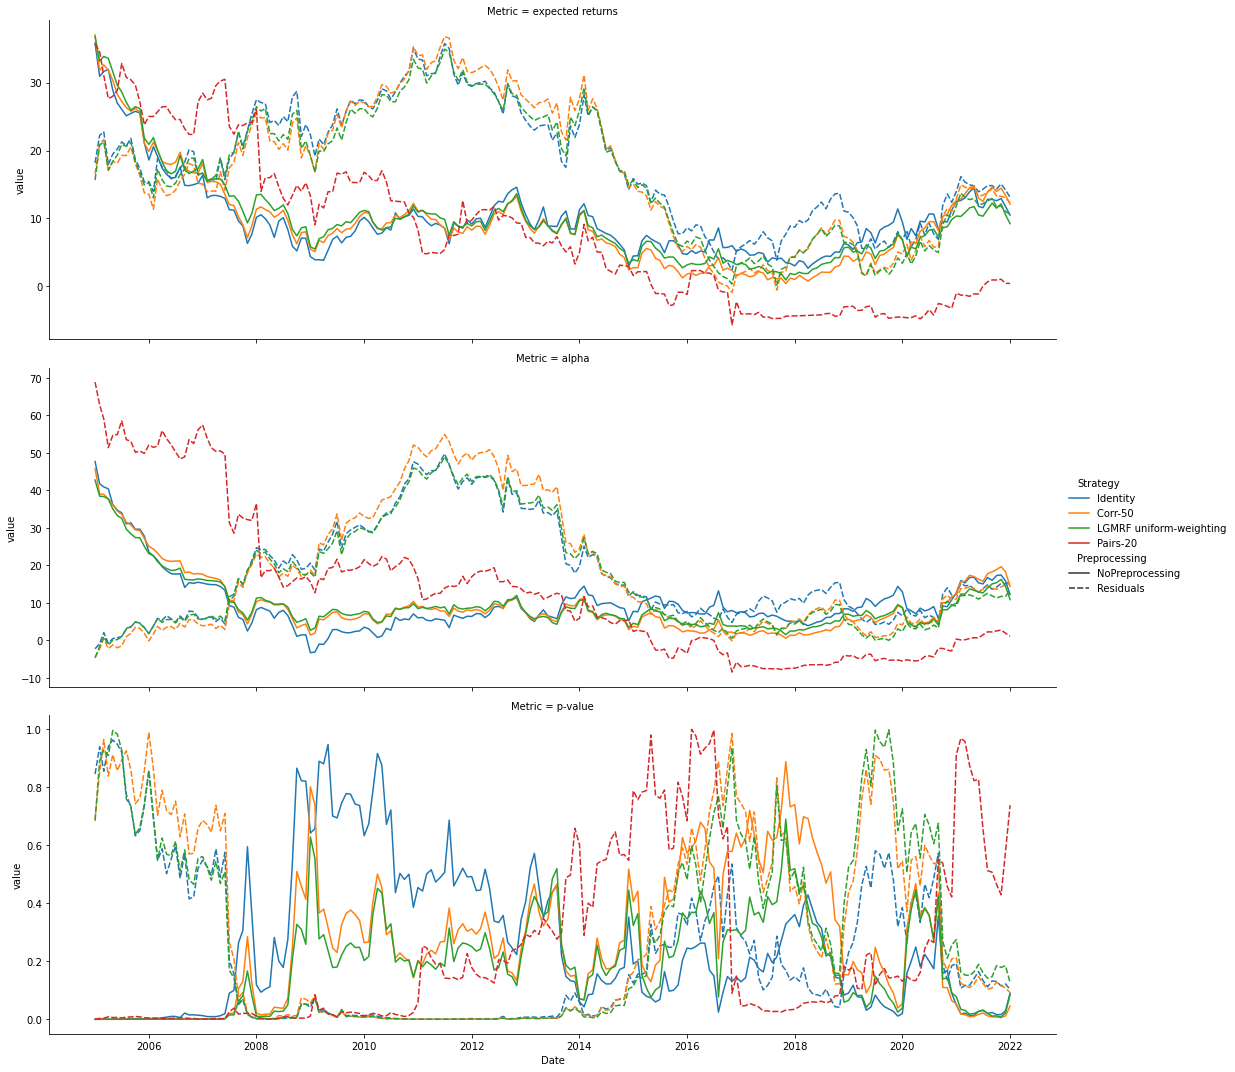

In [363]:
# fig, ax = plt.subplots(figsize=(16, 10))
sns.relplot(data=rolling_alpha_plots_df_melt, x='Date', y='value', 
            hue='Strategy', style='Preprocessing', 
            row='Metric', kind='line', aspect=3, facet_kws=dict(sharey=False))
plt.show()
# sns.lineplot(data=garch_vol, x='Date', y='Garch Vol.')

In [368]:
rolling_alpha_plots_df_melt['Category'] = rolling_alpha_plots_df_melt['Strategy'].apply(lambda x: 'Pairs' if x.startswith('Pairs') else "Spreads")

In [371]:
row_vals

array(['expected returns', 'alpha', 'p-value'], dtype=object)

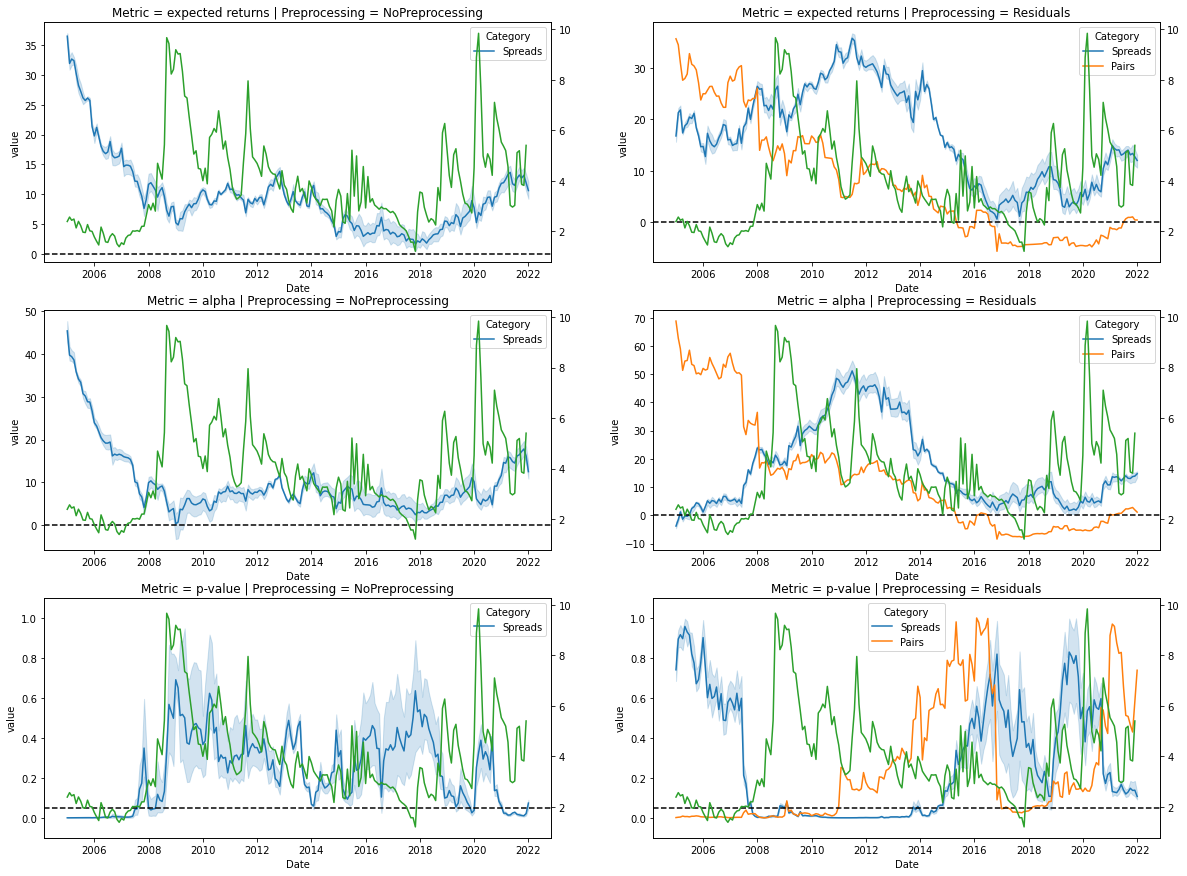

In [375]:
col = 'Preprocessing'
row = 'Metric'
x = 'Date'
y = 'value'
hue = 'Category'
row_vals = rolling_alpha_plots_df_melt[row].unique()
col_vals = rolling_alpha_plots_df_melt[col].unique()

fig, axs = plt.subplots(row_vals.size, col_vals.size, figsize=(20, 15))

for i, row_val in enumerate(row_vals):
    for j, col_val in enumerate(col_vals):
        sns.lineplot(data=rolling_alpha_plots_df_melt[((rolling_alpha_plots_df_melt[col] == col_val) & 
                                                       (rolling_alpha_plots_df_melt[row] == row_val))], 
                     x = x, y=y, hue=hue,
                     ax=axs[i, j])
        ax2 = axs[i, j].twinx()
        ax2.plot(garch_vol['Date'], garch_vol['Garch Vol.'], color='tab:green')
        if row_val != 'p-value':
            axs[i, j].axhline(0, color='black', ls='--')
        else:
            axs[i, j].set_ylim(-.1, 1.1)
            axs[i, j].axhline(0.05, color='black', ls='--')
        axs[i, j].set_title(f'{row} = {row_val} | {col} = {col_val}')

In [298]:
# window = 12
aux_df = rolling_alpha_plots_df_melt.groupby(['Date', 'Metric', 'Preprocessing'])['value'].mean().reset_index()
aux_df['Configuration'] = aux_df['Preprocessing'] + ' ' + aux_df['Metric']
aux_df = aux_df.pivot(index='Date', columns='Configuration', values='value').reset_index().merge(garch_vol).drop(columns='Date')
aux_df.corr()[['Garch Vol.']].drop('Garch Vol.').round(4).sort_index() #.sort_values('Garch Vol.')

,Garch Vol.
NoPreprocessing alpha,0.2226
NoPreprocessing expected returns,0.2283
NoPreprocessing p-value,-0.0998
Residuals alpha,0.0698
Residuals expected returns,0.1093
Residuals p-value,0.1375


In [292]:
# window = 60
aux_df = rolling_alpha_plots_df_melt.groupby(['Date', 'Metric', 'Preprocessing'])['value'].mean().reset_index()
aux_df['Configuration'] = aux_df['Preprocessing'] + ' ' + aux_df['Metric']
aux_df = aux_df.pivot(index='Date', columns='Configuration', values='value').reset_index().merge(garch_vol).drop(columns='Date')
aux_df.corr()[['Garch Vol.']].drop('Garch Vol.').round(4).sort_index() #.sort_values('Garch Vol.')

,Garch Vol.
NoPreprocessing alpha,-0.3561
NoPreprocessing expected returns,-0.2495
NoPreprocessing p-value,0.3967
Residuals alpha,0.3603
Residuals expected returns,0.2327
Residuals p-value,-0.4212


In [302]:
# window = 120
aux_df = rolling_alpha_plots_df_melt.groupby(['Date', 'Metric', 'Preprocessing'])['value'].mean().reset_index()
aux_df['Configuration'] = aux_df['Preprocessing'] + ' ' + aux_df['Metric']
aux_df = aux_df.pivot(index='Date', columns='Configuration', values='value').reset_index().merge(garch_vol).drop(columns='Date')
aux_df.corr()[['Garch Vol.']].drop('Garch Vol.').round(4).sort_index() #.sort_values('Garch Vol.')

,Garch Vol.
NoPreprocessing alpha,0.4171
NoPreprocessing expected returns,0.3318
NoPreprocessing p-value,-0.4080
Residuals alpha,-0.1479
Residuals expected returns,-0.0233
Residuals p-value,0.1910


In [306]:
# window = 240
aux_df = rolling_alpha_plots_df_melt.groupby(['Date', 'Metric', 'Preprocessing'])['value'].mean().reset_index()
aux_df['Configuration'] = aux_df['Preprocessing'] + ' ' + aux_df['Metric']
aux_df = aux_df.pivot(index='Date', columns='Configuration', values='value').reset_index().merge(garch_vol).drop(columns='Date')
aux_df.corr()[['Garch Vol.']].drop('Garch Vol.').round(4).sort_index() #.sort_values('Garch Vol.')

,Garch Vol.
NoPreprocessing alpha,0.6519
NoPreprocessing expected returns,0.7586
NoPreprocessing p-value,-0.6596
Residuals alpha,-0.6155
Residuals expected returns,0.1888
Residuals p-value,0.4195


In [376]:
rolling_alpha_plots_df_melt[((rolling_alpha_plots_df_melt['Metric'] == 'p-value') &
                             (rolling_alpha_plots_df_melt['Preprocessing'] == 'NoPreprocessing'))].groupby(['Preprocessing', 'Strategy'])[['value']].apply(
    lambda x: pd.Series({
    'P-value < 0.1': (x.values < .1).mean(),
    'P-value < 0.05': (x.values < .05).mean(),
    'P-value < 0.01': (x.values < .01).mean(),
    'P-value < 0.001': (x.values < .001).mean(),
})).round(3).style.highlight_max().format('{:.3f}')

In [377]:
rolling_alpha_plots_df_melt[((rolling_alpha_plots_df_melt['Metric'] == 'p-value') &
                             (rolling_alpha_plots_df_melt['Preprocessing'] == 'Residuals'))].groupby(['Preprocessing', 'Strategy'])[['value']].apply(
    lambda x: pd.Series({
    'P-value < 0.1': (x.values < .1).mean(),
    'P-value < 0.05': (x.values < .05).mean(),
    'P-value < 0.01': (x.values < .01).mean(),
    'P-value < 0.001': (x.values < .001).mean(),
})).round(3).style.highlight_max().format('{:.3f}')

In [319]:
with open("results/grid_backtester.pkl", "rb") as input_file:
    backtester = pickle.load(input_file)

In [351]:
L_lgmrf = backtester._configs['NoPreprocessing LGMRF']._split_backtesters[-1]._trader._L
((((np.diag(np.diag(L_lgmrf)) - L_lgmrf) > 0).sum(axis=0)).mean(), 
 (((np.diag(np.diag(L_lgmrf)) - L_lgmrf) > 0).sum(axis=0)).mean() / L_lgmrf.shape[1] * 100)

(34.585480093676814, 8.099644050041409)

In [350]:
L_ltmrf = backtester._configs['NoPreprocessing LTMRF']._split_backtesters[-1]._trader._L
((((np.diag(np.diag(L_ltmrf)) - L_ltmrf) > 0).sum(axis=0)).mean(), 
 (((np.diag(np.diag(L_ltmrf)) - L_ltmrf) > 0).sum(axis=0)).mean() / L_ltmrf.shape[1] * 100)

(3.451990632318501, 0.8084287195125295)

In [352]:
L_lgmrf.shape[1]

427